<a href="https://colab.research.google.com/github/who-knows-its-nebulose/chair-style-classifier/blob/main/Train_chair_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install split_folders
import splitfolders

In [ ]:
# Split 70:15:15 into training, validation and test

splitfolders.ratio('/content/drive/My Drive/colabdownloads/chairs/', output="/content/drive/My Drive/DS_projects/chair_classifier/", seed=1337, ratio=(.7, 0.15,0.15))

In [4]:
#Import libraries
import os
import numpy as np
from pathlib import Path
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

#variables
img_height = 224
img_width = 224
batch_size = 32
N_CLASSES = 4


#data generation
data_path = '/content/drive/My Drive/DS_projects/chair_classifier/'
train_data_path = data_path + 'train/'
val_data_path = data_path + 'val/'
test_data_path = data_path + 'test/'


train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=20,
                                  #  width_shift_range=0.1,
                                  #  height_shift_range=0.1,
                                   shear_range=0.2,
                                  #  zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_data_path,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle = False,
                                                        class_mode='categorical')




Found 1344 images belonging to 4 classes.
Found 287 images belonging to 4 classes.
Found 291 images belonging to 4 classes.


['Farmhouse', 'Industrial', 'Midcentury', 'Tropical']


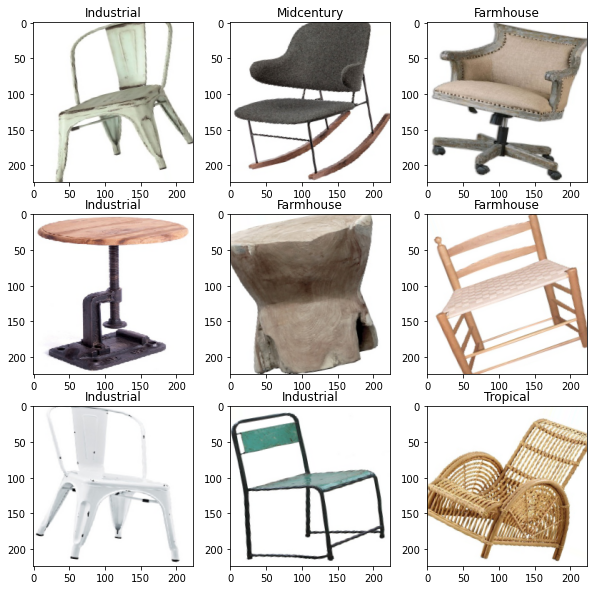

In [5]:
# Mapping class indices to category names
labels_train = []
dict_train = (test_generator.class_indices)

for key, value in dict_train.items():
   labels_train.append(key)
print(labels_train)


# Visualize input data (augmented training images)

x,y = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(0,9):
    ax = plt.subplot(3, 3, i + 1)
    image = x[i]
    label = labels_train[np.argmax(y[i])]
    plt.imshow(image)
    plt.title(label)
  


In [6]:
#base model MobilenetV2

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, 
                                                           img_width,
                                                              3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = 'max',
                                               alpha = 1.4)

base_model.trainable = False

base_model.summary()




Model: "mobilenetv2_1.40_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 48) 1296        Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 48) 192         Conv1[0][0]                      
_______________________________________________________________________________

In [7]:
#build model
kernel_init = tf.keras.initializers.glorot_uniform(seed=1337)
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
preprocessed_input = preprocess_input(inputs)
base_model_out = base_model(preprocessed_input, training=False)
dense1 = Dense(256, activation = 'relu')(base_model_out)
drop2 = Dropout(0.3)(dense1)
dense2 = Dense(256, activation = 'relu')(drop2)
drop3 = Dropout(0.2)(dense2)
outputs = Dense(N_CLASSES, activation='softmax', kernel_initializer = kernel_init)(drop3)
model = tf.keras.Model(inputs, outputs)

# model.summary()
len(model.trainable_variables)


6

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

checkpoint_filepath = "/content/drive/My Drive/Colab Notebooks/checkpoints_test/{epoch:02d}_{val_accuracy:.4f}.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy', 
    mode='max', 
    verbose=1,    
    save_best_only=True)   
 
reduce_lr =  ReduceLROnPlateau(patience=3, monitor='val_accuracy', factor = 0.2 , min_lr=1e-7, verbose=1)

early_stopping = EarlyStopping(patience=6, monitor='val_accuracy', restore_best_weights=True, mode='max',verbose=1,min_delta=0.001)
          
Callbacks=[model_checkpoint_callback, reduce_lr, early_stopping]    

In [9]:
TRAIN_DATASET_SIZE = len(train_generator)
VAL_DATASET_SIZE   = len(val_generator)

# Weighted losses for class equilibrium
# unique, counts = np.unique(ds_train.class_names, return_counts=True)
# class_weights = dict(zip(unique, np.true_divide(counts.sum(), N_CLASSES*counts)))
#/content/drive/My Drive/Colab Notebooks


# Prepare model to run


base_learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )
INITIAL_EPOCH = 0
TOTAL_EPOCHS = 50
# Start training the model
history = model.fit(train_generator,
                    epochs=TOTAL_EPOCHS,
                    verbose=1,
                    steps_per_epoch=TRAIN_DATASET_SIZE,
                    validation_data=val_generator,
                    validation_steps=VAL_DATASET_SIZE,
                    initial_epoch=INITIAL_EPOCH,
                    callbacks=[model_checkpoint_callback, reduce_lr, early_stopping]
                    )

Epoch 1/50
42/42 [==============================] - ETA: 0s - loss: 1.4627 - accuracy: 0.4048
Epoch 00001: val_accuracy improved from -inf to 0.48432, saving model to /content/drive/My Drive/Colab Notebooks/checkpoints_test/01_0.4843.h5
42/42 [==============================] - 18s 425ms/step - loss: 1.4627 - accuracy: 0.4048 - val_loss: 1.2410 - val_accuracy: 0.4843
Epoch 2/50
42/42 [==============================] - ETA: 0s - loss: 1.2583 - accuracy: 0.4583
Epoch 00002: val_accuracy improved from 0.48432 to 0.54704, saving model to /content/drive/My Drive/Colab Notebooks/checkpoints_test/02_0.5470.h5
42/42 [==============================] - 17s 400ms/step - loss: 1.2583 - accuracy: 0.4583 - val_loss: 1.1391 - val_accuracy: 0.5470
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 1.1998 - accuracy: 0.4866
Epoch 00003: val_accuracy did not improve from 0.54704
42/42 [==============================] - 17s 393ms/step - loss: 1.1998 - accuracy: 0.4866 - val_loss: 1.1394 -

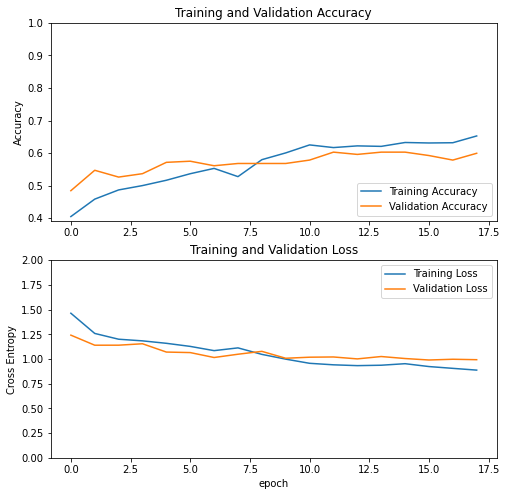

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [11]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix

#num_of_test_samples = 261

Y_pred = model.predict(test_generator)#, num_of_test_samples // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')

#Mapping class indices to category names
labels = []
dict = (test_generator.class_indices)

for key, value in dict.items():
   labels.append(key)


print(classification_report(test_generator.classes, y_pred, target_names=labels))

Confusion Matrix
[[61 12  3 20]
 [15 51  8  7]
 [ 3 10 25 11]
 [ 6 13  4 42]]
Classification Report
              precision    recall  f1-score   support

   Farmhouse       0.72      0.64      0.67        96
  Industrial       0.59      0.63      0.61        81
  Midcentury       0.62      0.51      0.56        49
    Tropical       0.53      0.65      0.58        65

    accuracy                           0.62       291
   macro avg       0.62      0.61      0.61       291
weighted avg       0.62      0.62      0.62       291



In [12]:
#Retreive the epoch number and weights from the highest val_accuracy pass


chair_checkpoint_path = '/content/drive/My Drive/Colab Notebooks/checkpoints_test/'
if Path(chair_checkpoint_path).exists():
  epoch_number_array = []
  val_accuracy_array = []
  file_name_array = []
  for file in os.listdir(chair_checkpoint_path):
      epoch, val_ac = re.search(r'(\d\d)_(\d\.\d{4})\.h5', file).group(1,2)
      epoch_number_array.append(int(epoch))
      val_accuracy_array.append(float(val_ac))
      file_name_array.append(file)

      if len(val_accuracy_array) == 0:
        INITIAL_EPOCH = 0
      else:
        highest_acc = val_accuracy_array.index(max(val_accuracy_array))
        INITIAL_EPOCH = epoch_number_array[highest_acc]
        model_checkpoint_callback.best = val_accuracy_array[highest_acc]
        model.load_weights(chair_checkpoint_path + file_name_array[highest_acc])
else:
  os.makedirs(chair_checkpoint_path)
  INITIAL_EPOCH = 0

In [13]:
print(val_accuracy_array[highest_acc])
print(INITIAL_EPOCH)

0.6028
12


FINE TUNE

In [14]:
#Set base model to be trained 

base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# #Freeze everything below this layer and fine tune this layer onwards

# fine_tune_at = 20

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False


model.compile(optimizer = Adam(learning_rate=base_learning_rate/100),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )
model.summary()

len(model.trainable_variables)

Number of layers in the base model:  156
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.40_224 (Functi (None, 1792)              4363712   
_________________________________________________________________
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dens

162

In [15]:
FINE_EPOCHS = 20


history_fine = model.fit(train_generator,
                        epochs=TOTAL_EPOCHS + FINE_EPOCHS,
                        verbose=1,
                        steps_per_epoch=TRAIN_DATASET_SIZE,
                        validation_data=val_generator,
                        validation_steps=VAL_DATASET_SIZE,
                        initial_epoch=INITIAL_EPOCH,
                        callbacks=[model_checkpoint_callback, reduce_lr, early_stopping]
                        )

Epoch 13/70
42/42 [==============================] - ETA: 0s - loss: 1.3881 - accuracy: 0.3951
Epoch 00013: val_accuracy did not improve from 0.60280
42/42 [==============================] - 17s 414ms/step - loss: 1.3881 - accuracy: 0.3951 - val_loss: 1.2181 - val_accuracy: 0.4878
Epoch 14/70
42/42 [==============================] - ETA: 0s - loss: 1.2055 - accuracy: 0.4821
Epoch 00014: val_accuracy did not improve from 0.60280
42/42 [==============================] - 17s 406ms/step - loss: 1.2055 - accuracy: 0.4821 - val_loss: 1.1416 - val_accuracy: 0.5575
Epoch 15/70
42/42 [==============================] - ETA: 0s - loss: 1.1077 - accuracy: 0.5409
Epoch 00015: val_accuracy did not improve from 0.60280
42/42 [==============================] - 17s 398ms/step - loss: 1.1077 - accuracy: 0.5409 - val_loss: 1.0417 - val_accuracy: 0.5854
Epoch 16/70
42/42 [==============================] - ETA: 0s - loss: 1.0678 - accuracy: 0.5685
Epoch 00016: val_accuracy improved from 0.60280 to 0.62021,

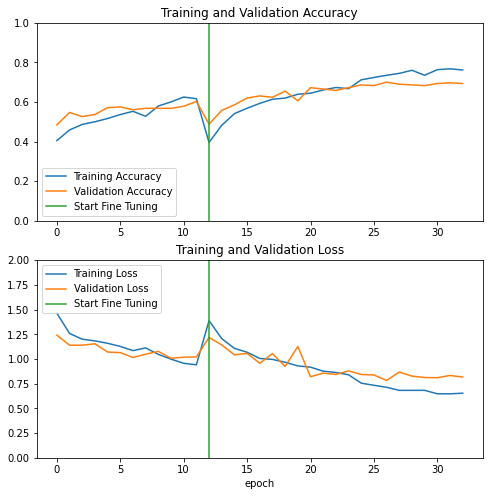

In [18]:
# del acc[INITIAL_EPOCH:]
# del val_acc[INITIAL_EPOCH:]
# del loss[INITIAL_EPOCH:]
# del val_loss[INITIAL_EPOCH:]

# acc += history_fine.history['accuracy']
# val_acc += history_fine.history['val_accuracy']

# loss += history_fine.history['loss']
# val_loss += history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([INITIAL_EPOCH,INITIAL_EPOCH],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([INITIAL_EPOCH, INITIAL_EPOCH],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
Y_pred = model.predict(test_generator)#, num_of_test_samples // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')

#Mapping class indices to category names
labels = []
dict = (test_generator.class_indices)

for key, value in dict.items():
   labels.append(key)


print(classification_report(test_generator.classes, y_pred, target_names=labels))

Confusion Matrix
[[68  8  6 14]
 [10 64  5  2]
 [ 7 10 29  3]
 [13  6  3 43]]
Classification Report
              precision    recall  f1-score   support

   Farmhouse       0.69      0.71      0.70        96
  Industrial       0.73      0.79      0.76        81
  Midcentury       0.67      0.59      0.63        49
    Tropical       0.69      0.66      0.68        65

    accuracy                           0.70       291
   macro avg       0.70      0.69      0.69       291
weighted avg       0.70      0.70      0.70       291



In [20]:
model.save('/content/drive/My Drive/DS_projects/chair_classifier/model_chair_classifier_finetuned_v1.h5')


In [24]:
#TEST
from keras.models import load_model
from keras.preprocessing import image
from skimage.io import imread
from skimage.transform import rescale, resize

model_trained = load_model('/content/drive/My Drive/DS_projects/chair_classifier/model_chair_classifier_finetuned_v1.h5')




Enter your URLhttps://images2.imgix.net/p4dbimg/p20372/images/03-2-10315w-115.jpg?fit=fill&trim=color&trimcolor=FFFFFF&trimtol=5&bg=FFFFFF&w=768&h=576&fm=pjpg&auto=format
[[0.6180266  0.11906254 0.1918715  0.07103939]]
Farmhouse


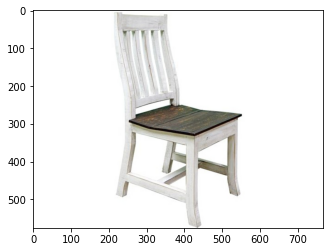

In [25]:
url = input('Enter your URL')
img = imread(url)
plt.imshow(img)
# class_names = ["Farmhouse", "Industrial", "Midcentury","Tropical"]

img_resized = resize(img,(224,224,3))
img_batch = np.expand_dims(img_resized,axis=0)
prediction_prob_array = model_trained.predict(img_batch)
print(prediction_prob_array)

max_prob_index = prediction_prob_array.argmax(axis=-1)
prediction = labels[max_prob_index[0]]
print(prediction)


Enter your URLhttps://503e4609daa2a3659421-930617c6e5227b562256fad405303714.ssl.cf1.rackcdn.com/Walmart-DrewBarrymore/atf360s/756909210_08.jpg
[[0.14521845 0.09398213 0.68716043 0.07363894]]
Midcentury


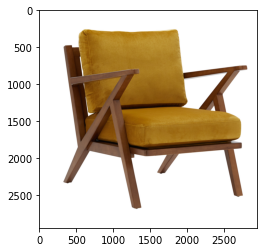

In [26]:
url = input('Enter your URL')
img = imread(url)
plt.imshow(img)
# class_names = ["Farmhouse", "Industrial", "Midcentury","Tropical"]

img_resized = resize(img,(224,224,3))
img_batch = np.expand_dims(img_resized,axis=0)
prediction_prob_array = model_trained.predict(img_batch)
print(prediction_prob_array)

max_prob_index = prediction_prob_array.argmax(axis=-1)
prediction = labels[max_prob_index[0]]
print(prediction)

Enter your URLhttps://images.affordableseating.net/dpr_1.0,f_auto,q_auto,w_2000,h_2000/afd/media/catalog/product/2/3/239-gm-wb-dkw-ws-dkw-1.jpg
[[0.00154862 0.9392413  0.05158857 0.00762155]]
Industrial


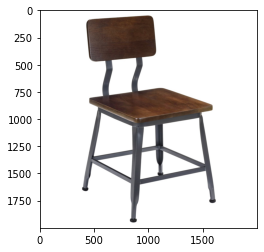

In [27]:
url = input('Enter your URL')
img = imread(url)
plt.imshow(img)
# class_names = ["Farmhouse", "Industrial", "Midcentury","Tropical"]

img_resized = resize(img,(224,224,3))
img_batch = np.expand_dims(img_resized,axis=0)
prediction_prob_array = model_trained.predict(img_batch)
print(prediction_prob_array)

max_prob_index = prediction_prob_array.argmax(axis=-1)
prediction = labels[max_prob_index[0]]
print(prediction)